In [1]:
import torch
import torchvision
import torchaudio
import librosa
print("Everything loaded fine ✅")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Everything loaded fine ✅
Using device: cuda


In [13]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from PIL import Image
    
def get_dataloaders(data_dir, batch_size=32):
    train_transform = transforms.Compose([
        transforms.Resize((180, 180)),
        transforms.ToTensor()
    ])

    test_transform = transforms.Compose([
        transforms.Resize((180, 180)),
        transforms.ToTensor()
    ])

    full_dataset = datasets.ImageFolder(root=data_dir)
    total_length = len(full_dataset)
    train_length = int(0.7 * total_length)
    val_length = int(0.2 * total_length)
    test_length = total_length - train_length - val_length
    train_set, val_set, test_set = random_split(full_dataset, [train_length, val_length, test_length])

    # Apply transform separately for each set
    train_set.dataset.transform = train_transform
    val_set.dataset.transform = test_transform
    test_set.dataset.transform = test_transform

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [15]:
data_path = "./Data/images_original"  # Update this to your dataset path

train_loader, val_loader, test_loader = get_dataloaders(data_path)

for images, labels in train_loader:
    print("Batch of images shape:", images.shape)  # (batch_size, channels, height, width)
    print("Batch of labels shape:", labels.shape)  # (batch_size,)
    print("image dtype:", images.dtype)  # Should be torch.float32
    break  # Just show the first batch

Batch of images shape: torch.Size([32, 3, 180, 180])
Batch of labels shape: torch.Size([32])
image dtype: torch.float32


In [16]:
def evaluate_accuracy(model, data_loader):
    model.eval()
    total_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total_correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_correct / total

In [17]:
def train(model, train_loader, val_loader, optimizer, loss_fn, epochs=100, patience=10):
    best_val_acc = 0
    best_epoch = 0
    counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        val_acc = evaluate_accuracy(model, val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}, Val Acc: {val_acc:.2%}")

        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            counter = 0
            torch.save(model.state_dict(), "best_model.pth")  # Save best model
        else:
            counter += 1
            if counter >= patience:
                print(f"⏹️ Early stopping at epoch {epoch+1} — no improvement in {patience} epochs.")
                print(f"✅ Best Val Acc: {best_val_acc:.2%} at epoch {best_epoch+1}")
                break


In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, data_loader, class_names, title="Confusion Matrix"):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()


# Net1


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.fc1 = nn.Linear(3*180*180, 512)  # Input layer
        self.fc2 = nn.Linear(512, 128)  # Hidden layer
        self.output = nn.Linear(128, 10)  # Output layer (10 classes)

    def forward(self, x):
        x = x.view(x.size(0), -1) # Flatten the input
        x = F.relu(self.fc1(x)) # Activation function for the first layer
        x = F.relu(self.fc2(x)) # Activation function for the second layer
        x = self.output(x)
        return x

In [20]:
model = Net1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
loss_fn = nn.CrossEntropyLoss()

In [21]:
train (model, train_loader, val_loader, optimizer, loss_fn, epochs=50)
torch.save(model.state_dict(), "net1_fully_connected.pth")

Epoch 1/50, Loss: 219.4223, Val Acc: 8.04%
Epoch 2/50, Loss: 53.7631, Val Acc: 14.57%
Epoch 3/50, Loss: 46.3138, Val Acc: 25.63%
Epoch 4/50, Loss: 44.1167, Val Acc: 27.14%
Epoch 5/50, Loss: 42.3302, Val Acc: 28.64%
Epoch 6/50, Loss: 40.8495, Val Acc: 28.64%
Epoch 7/50, Loss: 38.2977, Val Acc: 36.18%
Epoch 8/50, Loss: 36.6904, Val Acc: 27.64%
Epoch 9/50, Loss: 36.3768, Val Acc: 39.20%
Epoch 10/50, Loss: 34.3476, Val Acc: 38.69%
Epoch 11/50, Loss: 31.3727, Val Acc: 34.17%
Epoch 12/50, Loss: 31.3692, Val Acc: 40.70%
Epoch 13/50, Loss: 29.5623, Val Acc: 36.18%
Epoch 14/50, Loss: 29.5679, Val Acc: 34.17%
Epoch 15/50, Loss: 27.4031, Val Acc: 39.20%
Epoch 16/50, Loss: 25.6391, Val Acc: 35.18%
Epoch 17/50, Loss: 25.2671, Val Acc: 36.68%
Epoch 18/50, Loss: 25.2804, Val Acc: 42.21%
Epoch 19/50, Loss: 23.3233, Val Acc: 26.13%
Epoch 20/50, Loss: 30.7430, Val Acc: 42.21%
Epoch 21/50, Loss: 24.1952, Val Acc: 42.21%
Epoch 22/50, Loss: 23.1217, Val Acc: 42.71%
Epoch 23/50, Loss: 23.6062, Val Acc: 37.1

In [12]:
train_acc = evaluate_accuracy(model, train_loader)
val_acc = evaluate_accuracy(model, val_loader)
test_acc = evaluate_accuracy(model, test_loader)

print(f"✅ Train Acc: {train_acc:.2%}")
print(f"✅ Val Acc: {val_acc:.2%}")
print(f"✅ Test Acc: {test_acc:.2%}")

✅ Train Acc: 68.24%
✅ Val Acc: 33.17%
✅ Test Acc: 39.60%


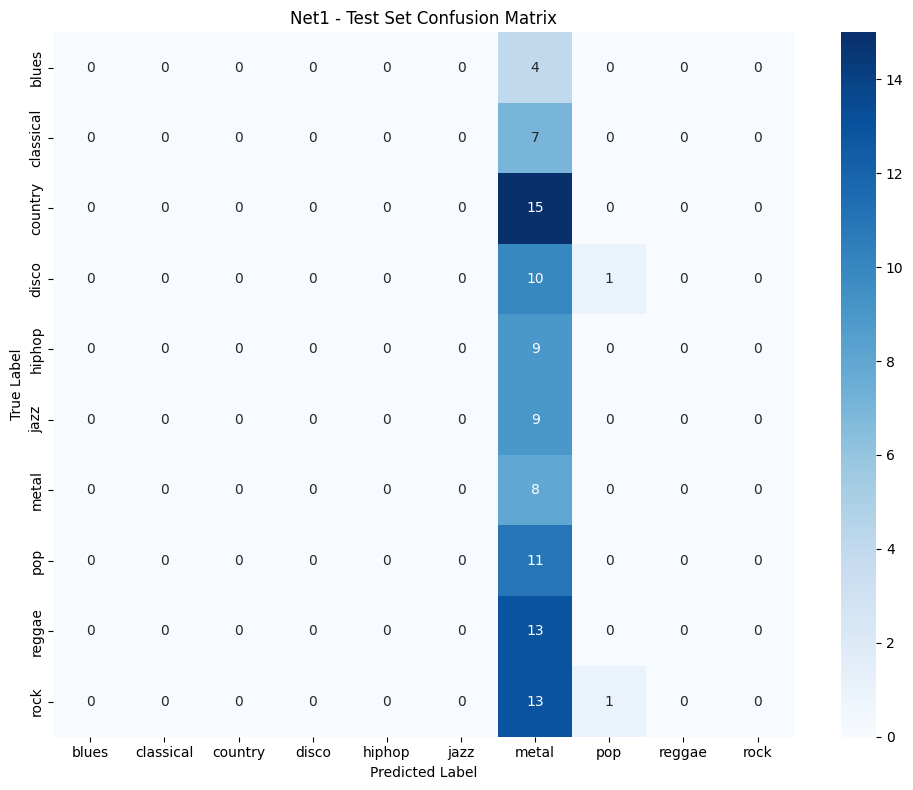

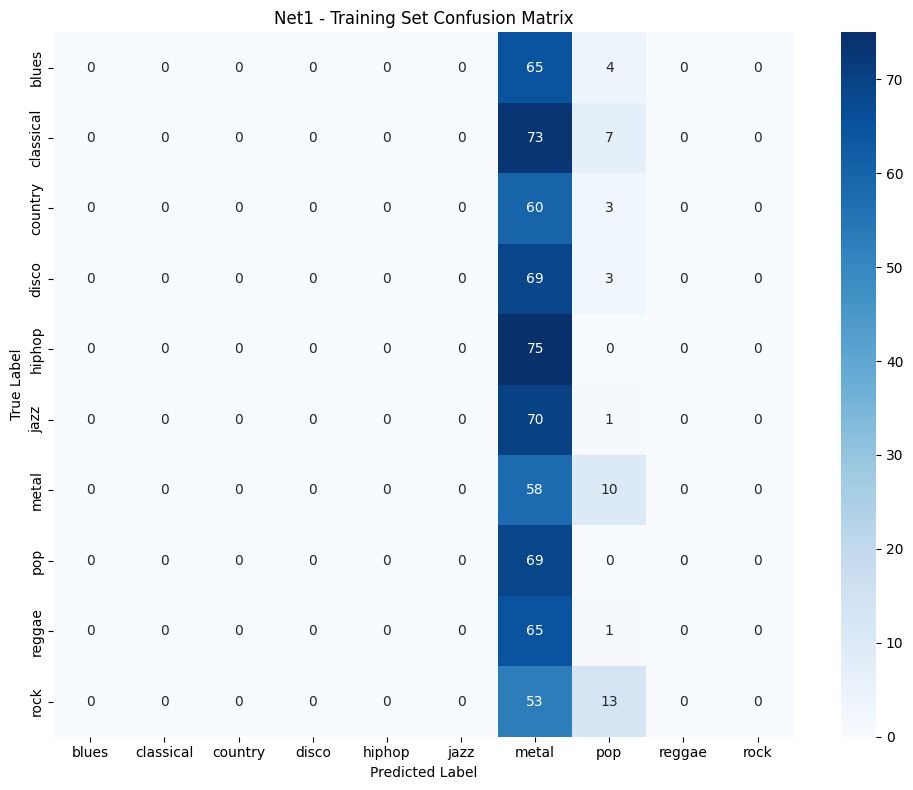

In [34]:
model = Net1().to(device)
model.eval()

class_names = train_loader.dataset.dataset.classes

plot_confusion_matrix(model, test_loader, class_names, title="Net1 - Test Set Confusion Matrix")
plot_confusion_matrix(model, train_loader, class_names, title="Net1 - Training Set Confusion Matrix")

# Net2


In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.5)
        
        # self.gap = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
        self.fc1 = nn.Linear(32 * 45 * 45, 256)
        self.fc2 = nn.Linear(256, 64)
        self.out = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)

        # x = self.gap(x)  # Now shape is [B, 32, 1, 1]
        x = x.view(x.size(0), -1)  # Flatten to [B, 32]
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.out(x)
        return x

In [48]:
model = Net2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
loss_fn = nn.CrossEntropyLoss()
train(model, train_loader, val_loader, optimizer, loss_fn, epochs=100)
torch.save(model.state_dict(), "net2_custom_cnn.pth")

Epoch 1/100, Loss: 50.9974, Val Acc: 9.05%
Epoch 2/100, Loss: 50.7521, Val Acc: 13.57%
Epoch 3/100, Loss: 50.3382, Val Acc: 9.05%
Epoch 4/100, Loss: 48.6879, Val Acc: 17.09%
Epoch 5/100, Loss: 47.3212, Val Acc: 19.10%
Epoch 6/100, Loss: 46.7164, Val Acc: 13.07%
Epoch 7/100, Loss: 46.7637, Val Acc: 17.59%
Epoch 8/100, Loss: 46.3163, Val Acc: 21.61%
Epoch 9/100, Loss: 45.6766, Val Acc: 22.11%
Epoch 10/100, Loss: 44.9363, Val Acc: 23.62%
Epoch 11/100, Loss: 44.9352, Val Acc: 25.13%
Epoch 12/100, Loss: 44.0961, Val Acc: 25.63%
Epoch 13/100, Loss: 43.4236, Val Acc: 26.63%
Epoch 14/100, Loss: 43.1296, Val Acc: 25.63%
Epoch 15/100, Loss: 42.7956, Val Acc: 27.14%
Epoch 16/100, Loss: 41.5228, Val Acc: 28.64%
Epoch 17/100, Loss: 40.5651, Val Acc: 30.15%
Epoch 18/100, Loss: 40.9826, Val Acc: 35.18%
Epoch 19/100, Loss: 39.9074, Val Acc: 36.18%
Epoch 20/100, Loss: 38.6625, Val Acc: 39.20%
Epoch 21/100, Loss: 39.0488, Val Acc: 39.70%
Epoch 22/100, Loss: 38.3070, Val Acc: 36.68%
Epoch 23/100, Loss: 3

In [49]:
train_acc = evaluate_accuracy(model, train_loader)
val_acc = evaluate_accuracy(model, val_loader)
test_acc = evaluate_accuracy(model, test_loader)

print(f"✅ Train Acc: {train_acc:.2%}")
print(f"✅ Val Acc: {val_acc:.2%}")
print(f"✅ Test Acc: {test_acc:.2%}")

✅ Train Acc: 90.41%
✅ Val Acc: 50.25%
✅ Test Acc: 40.59%


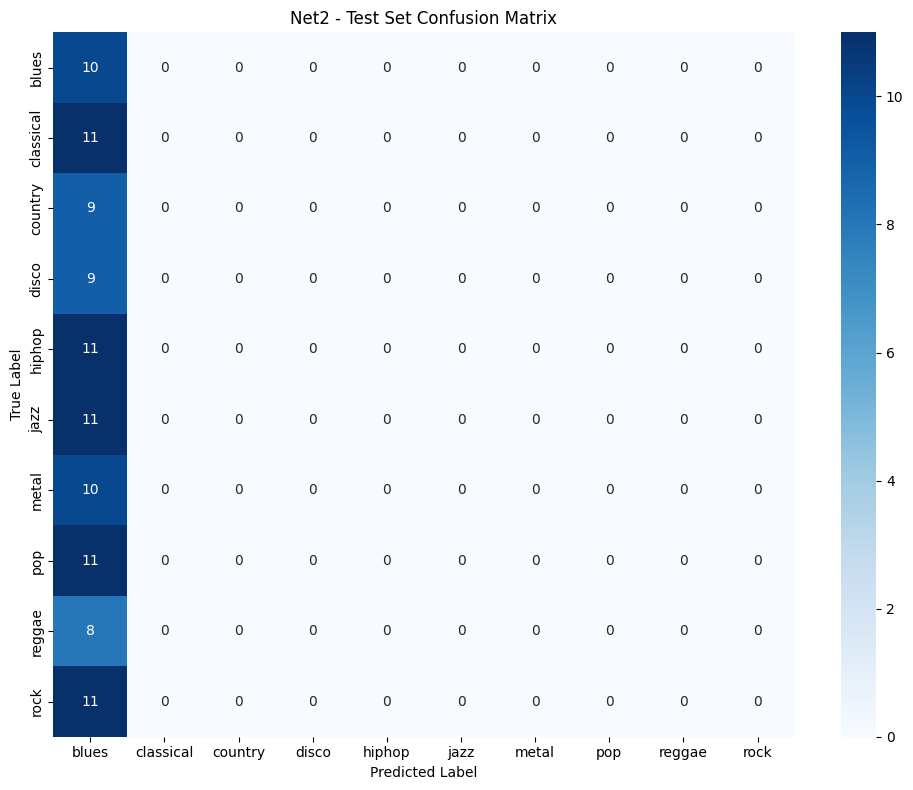

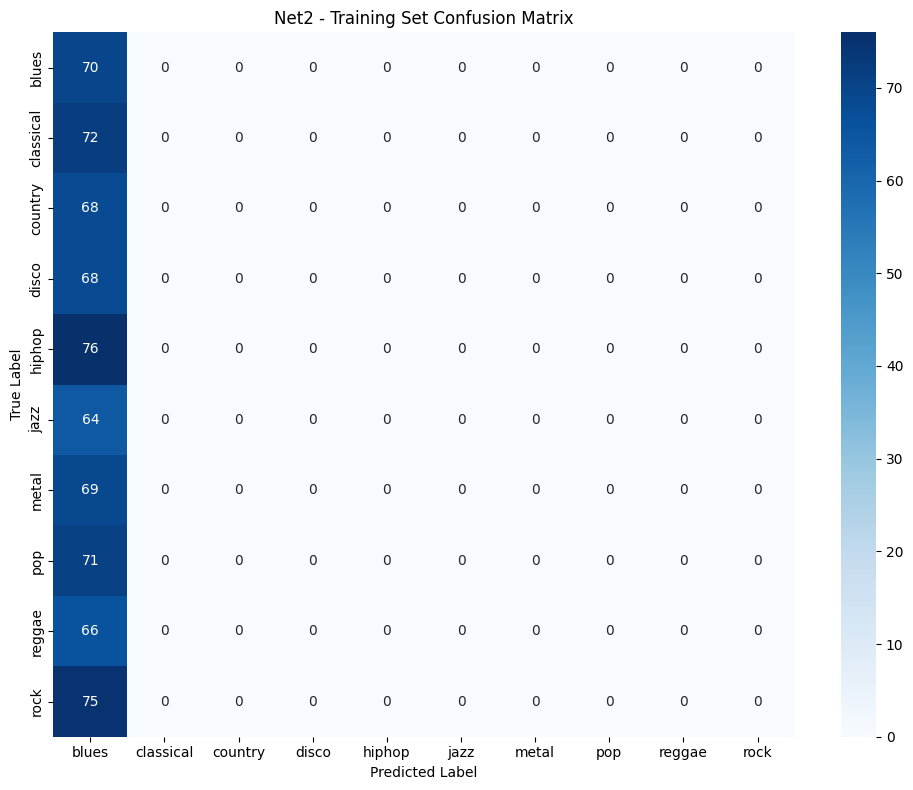

In [50]:
model = Net2().to(device)
model.eval()

class_names = train_loader.dataset.dataset.classes

plot_confusion_matrix(model, test_loader, class_names, title="Net2 - Test Set Confusion Matrix")
plot_confusion_matrix(model, train_loader, class_names, title="Net2 - Training Set Confusion Matrix")

# Net3


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(32)

        self.fc1 = nn.Linear(32 * 44 * 44, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 64)
        self.bn_fc2 = nn.BatchNorm1d(64)
        self.out = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.bn_fc1(self.fc1(x))))
        x = self.dropout(F.relu(self.bn_fc2(self.fc2(x))))
        x = self.out(x)
        return x



In [ ]:
model = Net3().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()
train(model, train_loader, val_loader, optimizer, loss_fn, epochs=50)
torch.save(model.state_dict(), "net3_cnn_bn.pth")

In [ ]:
train_acc = evaluate_accuracy(model, train_loader)
val_acc = evaluate_accuracy(model, val_loader)
test_acc = evaluate_accuracy(model, test_loader)

print(f"✅ Train Acc: {train_acc:.2%}")
print(f"✅ Val Acc: {val_acc:.2%}")
print(f"✅ Test Acc: {test_acc:.2%}")

# Net4


In [ ]:
model = Net3()  # CNN with 4 conv layers + BatchNorm
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
train(model, train_loader, val_loader, optimizer, loss_fn, epochs=50)
torch.save(model.state_dict(), "net4_cnn_bn_rmsprop.pth")